In [3]:
# Cell 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [4]:
# Cell 2: Load the data
# Assuming the data is already loaded
df = pd.read_csv("1.csv")


In [5]:
# Cell 3: Feature engineering - Add year and week of the year columns
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['week_of_year'] = df['transaction_date'].dt.isocalendar().week
df['year'] = df['transaction_date'].dt.year


In [6]:
# Cell 4: Function to aggregate sales data weekly
def aggregate_weekly_sales(df_product):
    weekly_sales = df_product.groupby(['year', 'week_of_year']).agg({'quantity': 'sum'}).reset_index()
    weekly_sales['date'] = pd.to_datetime(weekly_sales['year'].astype(str) + '-' + weekly_sales['week_of_year'].astype(str) + '-1', format='%Y-%W-%w')
    weekly_sales.set_index('date', inplace=True)
    
    # Exogenous variables: Here, we'll just use 'discount_applied' and 'product_stock' as features for simplicity.
    exogenous = df_product.groupby(['year', 'week_of_year']).agg({'discount_applied': 'mean', 'product_stock': 'mean'}).reset_index()
    exogenous['date'] = pd.to_datetime(exogenous['year'].astype(str) + '-' + exogenous['week_of_year'].astype(str) + '-1', format='%Y-%W-%w')
    exogenous.set_index('date', inplace=True)
    
    return weekly_sales['quantity'], exogenous[['discount_applied', 'product_stock']]


In [7]:
# Cell 5: Feature engineering and preprocessing
def feature_engineering_and_preprocessing(df_product):
    df_product['week_of_year'] = df_product['transaction_date'].dt.isocalendar().week
    df_product['year'] = df_product['transaction_date'].dt.year
    return df_product


In [9]:
# Function to train the SARIMAX model
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Function to train the SARIMAX model
# Function to train the SARIMAX model
def train_sarimax_model(df, product_id, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), forecast_steps=12):
    # Filter the data for the specific product_id
    df_product = df[df['product_id'] == product_id]
    if df_product.empty:
        raise ValueError(f"No data found for product ID {product_id}")
    
    # Feature engineering and preprocessing
    df_product = feature_engineering_and_preprocessing(df_product)
    
    # Aggregate the sales data to weekly sales
    weekly_sales, exogenous_weekly = aggregate_weekly_sales(df_product)
    
    # Check if we have enough data to train the model
    if len(weekly_sales) < forecast_steps or len(exogenous_weekly) < forecast_steps:
        raise ValueError(f"Not enough data to forecast. Required: {forecast_steps}, Available Sales: {len(weekly_sales)}, Available Exogenous: {len(exogenous_weekly)}")

    # Split data into train and test sets
    train_size = int(len(weekly_sales) * 0.8)  # 80% train, 20% test
    train_sales, test_sales = weekly_sales[:train_size], weekly_sales[train_size:]
    train_exog, test_exog = exogenous_weekly[:train_size], exogenous_weekly[train_size:]

    # Adjust the forecast_steps if not enough test data is available
    if len(test_exog) < forecast_steps:
        forecast_steps = len(test_exog)  # Use available exogenous data length

    # Ensure test_exog has the correct shape
    if len(test_exog) < forecast_steps:
        raise ValueError(f"Not enough exogenous data for forecasting. Required: {forecast_steps}, Available: {len(test_exog)}")
    
    # Train the SARIMAX model on the training data
    model = SARIMAX(train_sales, exog=train_exog, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    return model_fit, test_sales, test_exog

In [10]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Function to forecast and evaluate the model
def forecast_and_evaluate(model_fit, test_sales, test_exog, product_id, forecast_steps=12):
    # Adjust forecast_steps if not enough exogenous data is available
    if len(test_exog) < forecast_steps:
        forecast_steps = len(test_exog)  # Use available exogenous data length
    
    # Ensure test_exog has the correct shape
    if len(test_exog) < forecast_steps:
        raise ValueError(f"Not enough exogenous data for forecasting. Required: {forecast_steps}, Available: {len(test_exog)}")
    
    # Generate forecast
    forecast = model_fit.forecast(steps=forecast_steps, exog=test_exog[-forecast_steps:])  # Use the last forecast_steps rows
    
    # Calculate error metrics
    mae = mean_absolute_error(test_sales[:forecast_steps], forecast)
    rmse = np.sqrt(mean_squared_error(test_sales[:forecast_steps], forecast))
    mape = np.mean(np.abs((test_sales[:forecast_steps] - forecast) / test_sales[:forecast_steps])) * 100
    
    # Plotting the historical and forecasted sales
    plt.figure(figsize=(10, 6))
    plt.plot(test_sales.index, test_sales, label='Actual Sales', marker='o')
    plt.plot(test_sales.index[:forecast_steps], forecast, color='red', label='Forecasted Sales', marker='x')
    plt.title(f"Sales Forecast vs Actual for Product ID: {product_id}")  # Added product ID to title
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")
    
    return forecast, {"MAE": mae, "RMSE": rmse, "MAPE": mape}

/var/folders/q2/mr2wxd253jl7621ph74vbnwr0000gn/T/ipykernel_22674/4155495590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product['week_of_year'] = df_product['transaction_date'].dt.isocalendar().week
/var/folders/q2/mr2wxd253jl7621ph74vbnwr0000gn/T/ipykernel_22674/4155495590.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_product['year'] = df_product['transaction_date'].dt.year
/Users/shivanshmahajan/Desktop/slaes/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: Value

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/shivanshmahajan/Desktop/slaes/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/shivanshmahajan/Desktop/slaes/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/q2/mr2wxd253jl7621ph74vbnwr0000gn/T/ipykernel_22674/4073316913.py:22: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test_sales[:forecast_steps] - forecast) / test_sales[:forecast_steps])) * 100


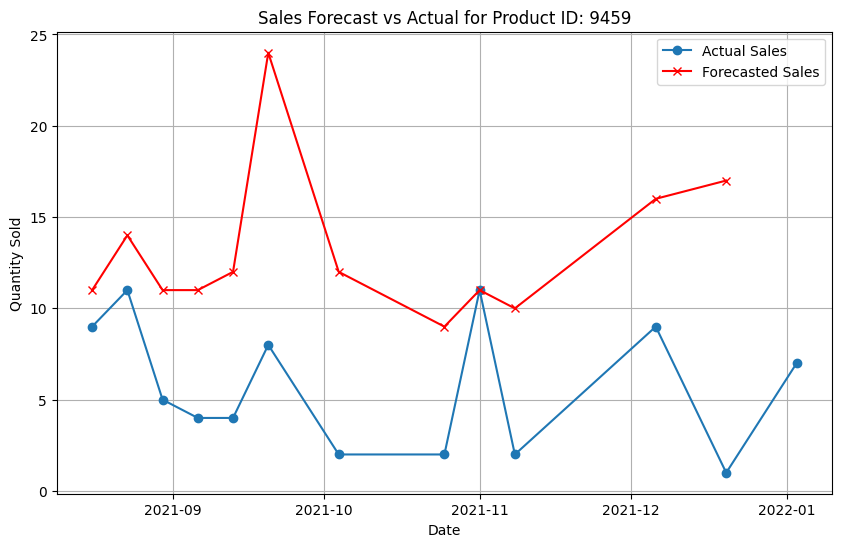

MAE: 7.500001374999314, RMSE: 8.83176211183199, MAPE: nan%


In [13]:
product_id = 9459
model_fit, test_sales, test_exog = train_sarimax_model(df, product_id)
forecast, metrics = forecast_and_evaluate(model_fit, test_sales, test_exog, product_id, forecast_steps=12)